In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [2]:
# Navigate to My Drive directory to store the dataset
%cd /kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI


/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI


In [4]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [7]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [8]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [9]:
brain_df[:5]

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [10]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [11]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,0,0)',
                  marker_line_width = 2, opacity = 0.6)
fig.show()

In [12]:
# Obtain the percentage of images with mask
round((brain_df['mask'].value_counts()* 100 / len(brain_df['mask'])),2)

0    65.05
1    34.95
Name: mask, dtype: float64

In [13]:
brain_df.mask_path[:5]

0    TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1    TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2    TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4    TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
Name: mask_path, dtype: object

In [14]:
brain_df.image_path[:5]

0    TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1    TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2    TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4    TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
Name: image_path, dtype: object

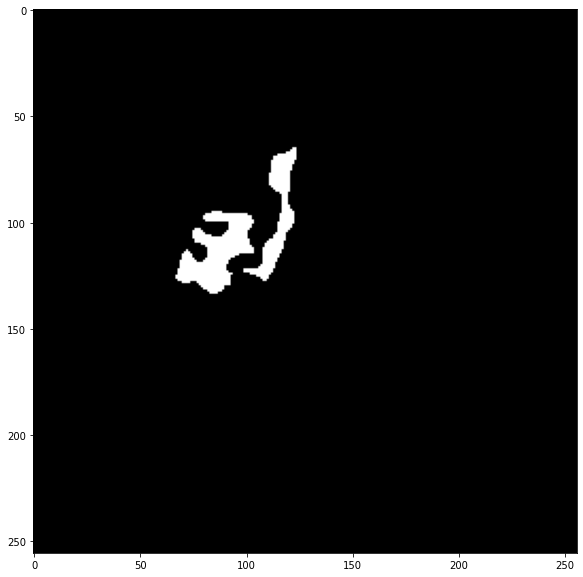

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.imread(brain_df.mask_path[2490]))
plt.show()

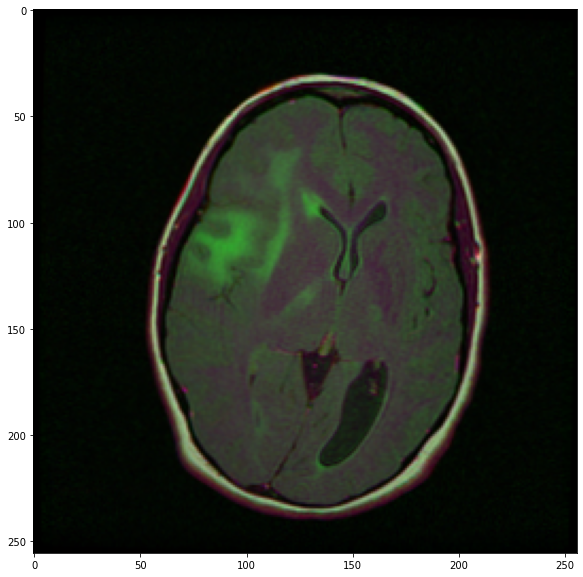

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.imread(brain_df.image_path[2490]))
plt.show()

In [17]:
cv2.imread(brain_df.mask_path[2490]).max()

255

In [18]:
cv2.imread(brain_df.mask_path[2490]).min()

0

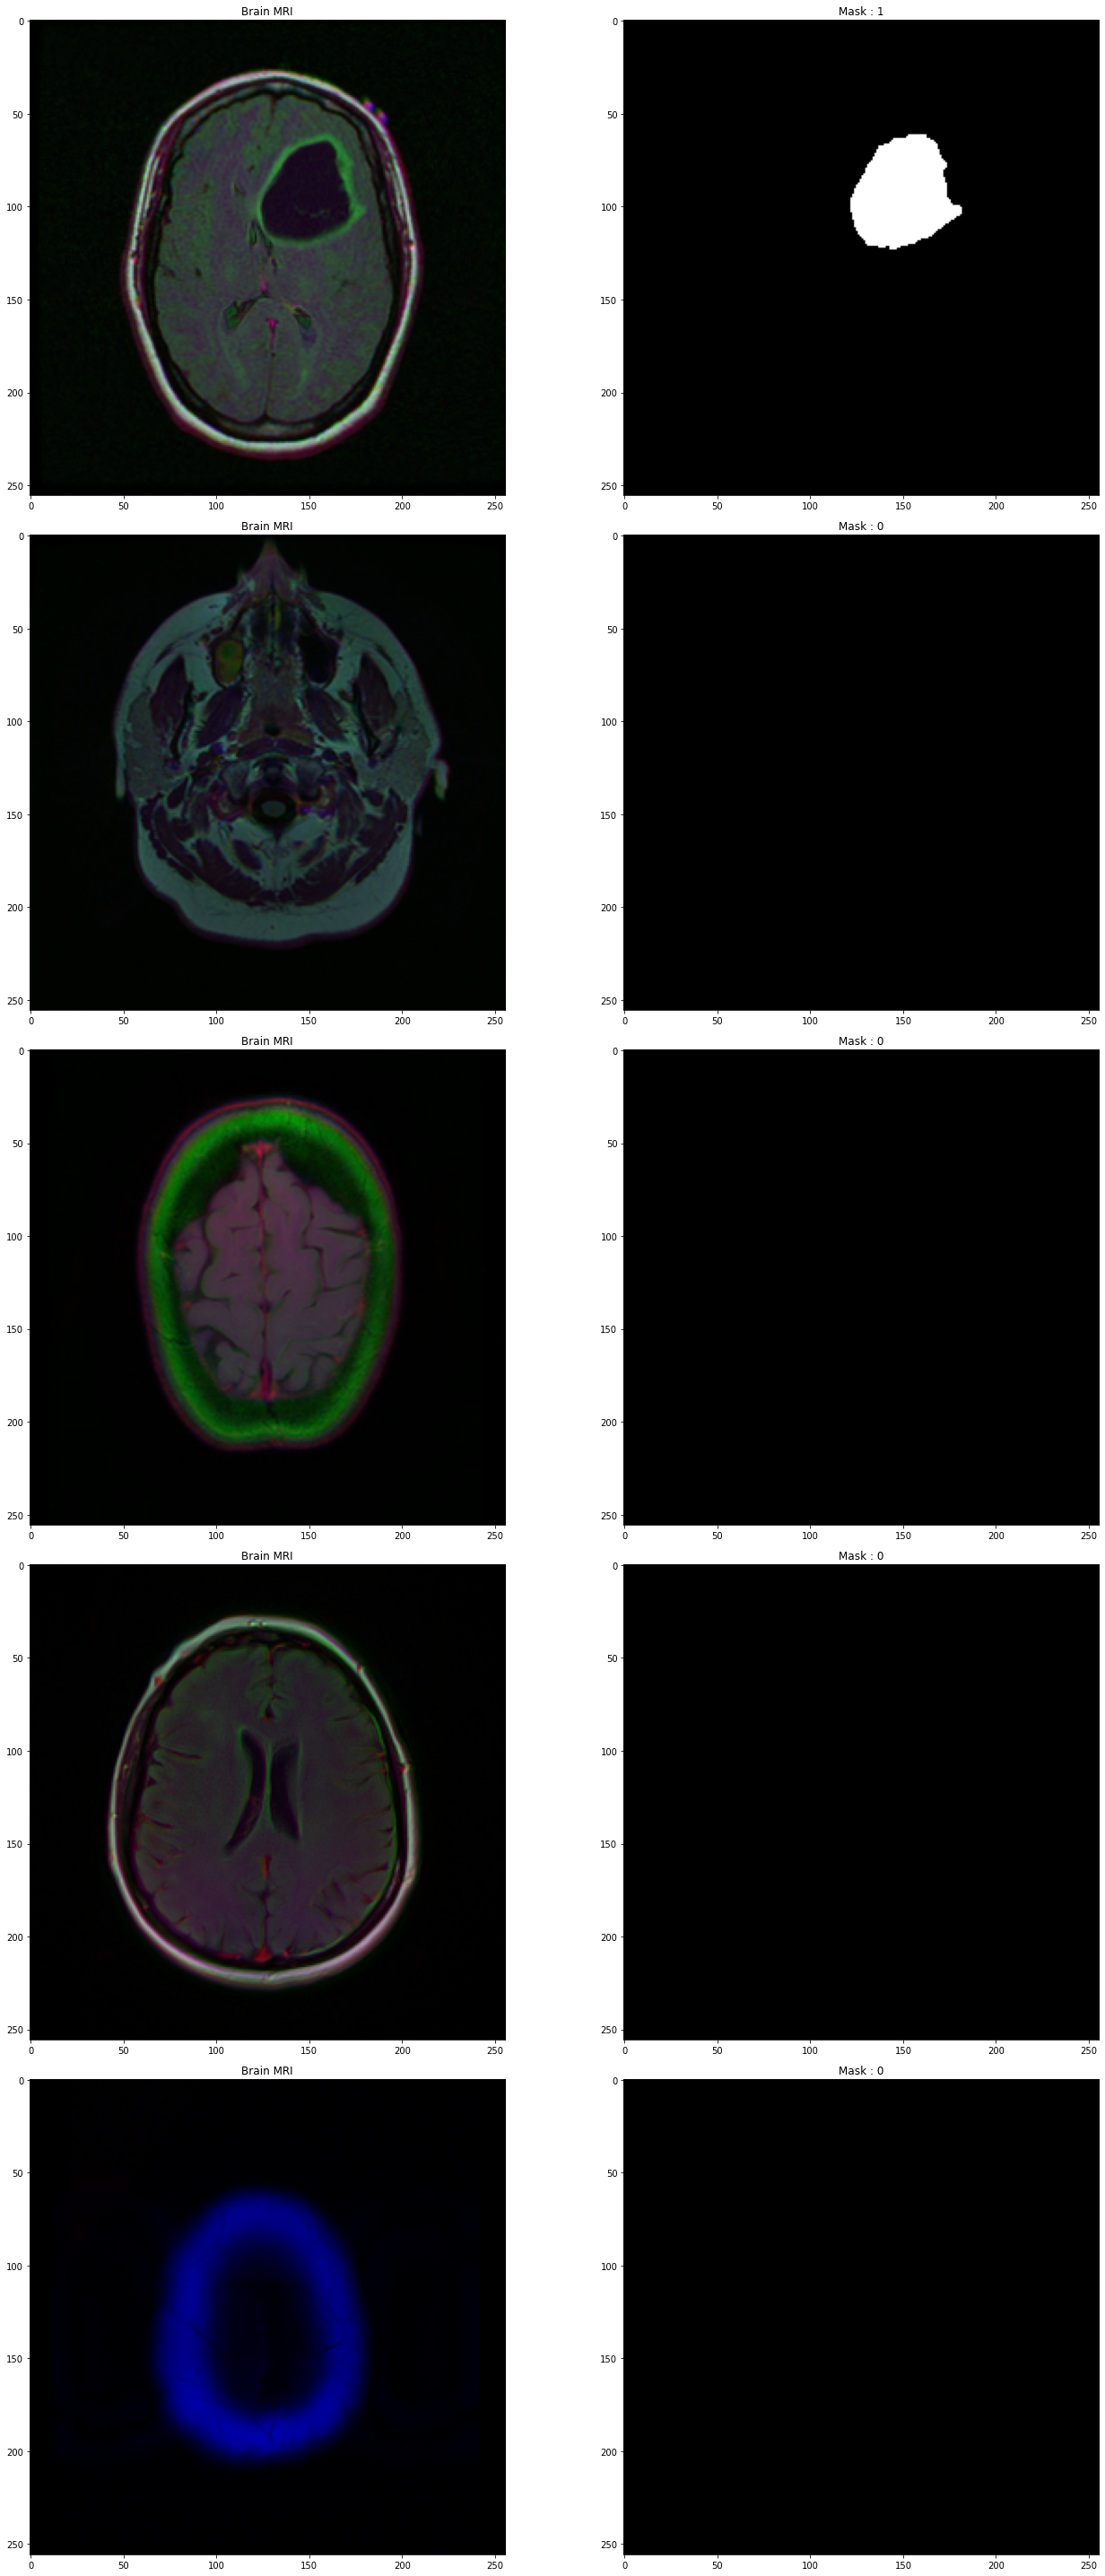

In [19]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(5,2, figsize=(20,40))
count = 0
for x in range(5):
  i = random.randint(0, len(brain_df)) # select a random index 
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask : " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

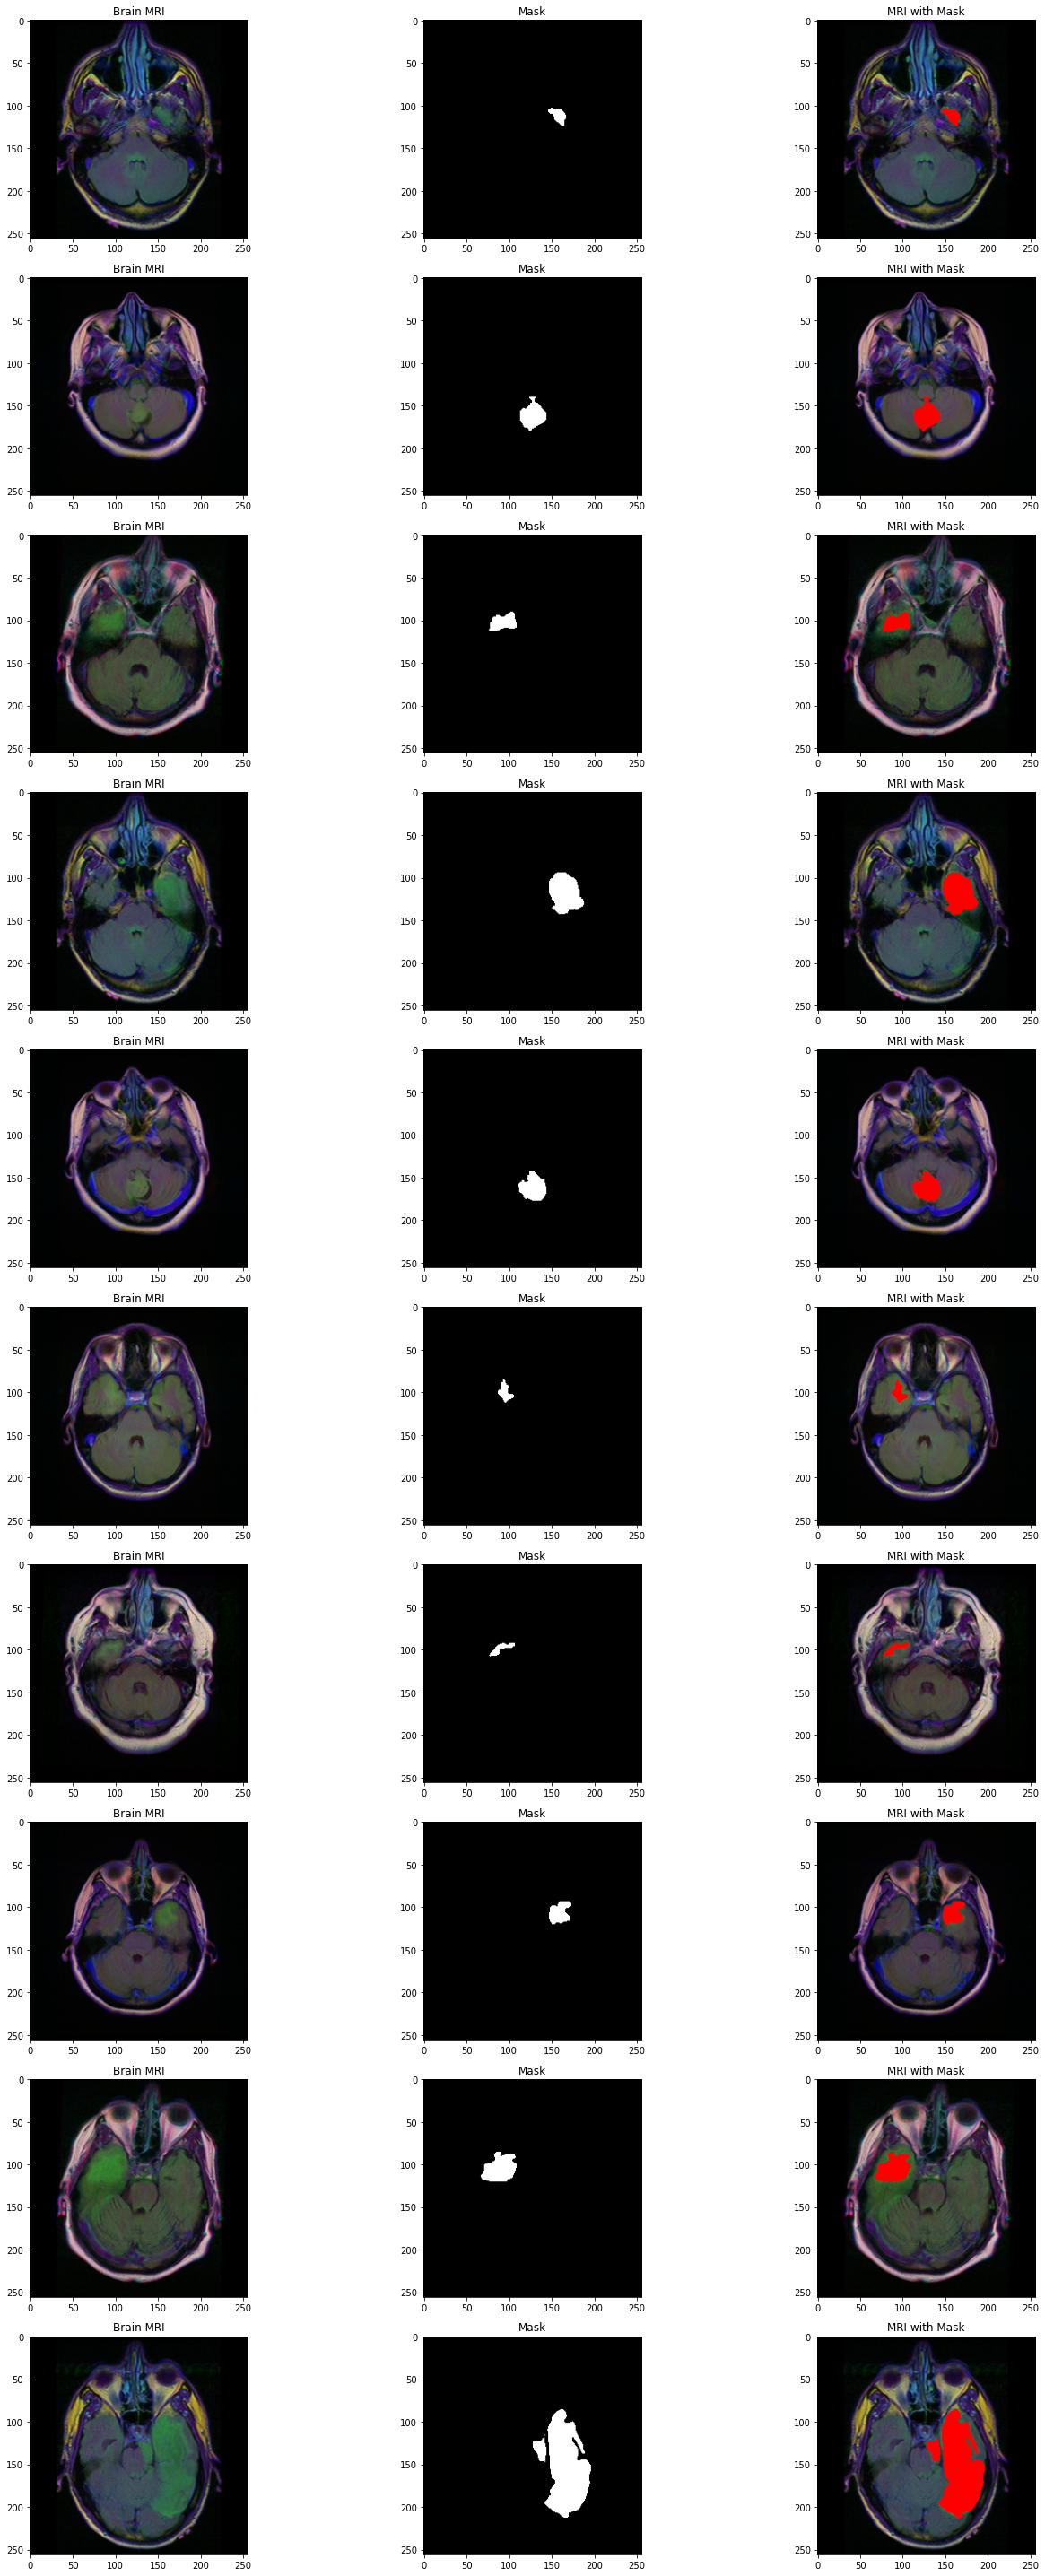

In [20]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image 
count = 0
fig, axs = plt.subplots(10, 3, figsize = (20, 40))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <10:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


In [21]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [22]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [23]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [24]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.2,random_state=42)

In [25]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.1
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.1)


In [26]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2829 validated image filenames belonging to 2 classes.
Found 314 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


In [27]:
# Get the ResNet50V2 base model
basemodel =ResNet50V2(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94683136/94668760 [==============================] - 1s 0us/step


In [29]:
basemodel.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [30]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [31]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [33]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=25
                             )
checkpointer = ModelCheckpoint(filepath="/kaggle/working/classifier-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [34]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [35]:
history = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 100, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks = [checkpointer, earlystopping, reduce_lr])

Epoch 1/100
176/176 [==============================] - 53s 218ms/step - loss: 0.7334 - accuracy: 0.6417 - val_loss: 0.6363 - val_accuracy: 0.6480

Epoch 00001: val_loss improved from inf to 0.63629, saving model to /kaggle/working/classifier-resnet-weights.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/100
176/176 [==============================] - 36s 203ms/step - loss: 0.6056 - accuracy: 0.6502 - val_loss: 0.6889 - val_accuracy: 0.6513

Epoch 00002: val_loss did not improve from 0.63629
Epoch 3/100
176/176 [==============================] - 37s 209ms/step - loss: 0.5483 - accuracy: 0.7096 - val_loss: 0.5318 - val_accuracy: 0.7039

Epoch 00003: val_loss improved from 0.63629 to 0.53180, saving model to /kaggle/working/classifier-resnet-weights.hdf5
Epoch 4/100
176/176 [==============================] - 37s 210ms/step - loss: 0.5968 - accuracy: 0.6872 - val_loss: 0.6303 - val_accuracy: 0.6513

Epoch 00004: val_loss did not improve from 0.53180
Epoch 5/100
176/176 [==============================] - 37s 209ms/step - loss: 0.6051 - accuracy: 0.6921 - val_loss: 1.7427 - val_accuracy: 0.6875

Epoch 00005: val_loss did not improve from 0.53180
Epoch 6/100
176/176 [==============================] - 37s 211ms/step - loss: 0.5817 - accuracy: 0.7032 - val_loss: 1.1669 - val_accuracy: 0

In [36]:
model_json = model.to_json()
with open("/kaggle/working/classifierresnetmodel.json", "w") as json_file:
    json_file.write(model_json)

In [37]:
with open('/kaggle/working/classifierresnetmodel.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/kaggle/working/classifier-resnet-weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [39]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

49/49 [==============================] - 6s 101ms/step


In [40]:
test_predict.shape

(784, 2)

In [41]:
test_predict[:5]

array([[1.6966087e-11, 1.0000000e+00],
       [9.6840155e-01, 3.1598497e-02],
       [9.9547654e-01, 4.5234733e-03],
       [6.3921893e-01, 3.6078110e-01],
       [9.9938428e-01, 6.1574474e-04]], dtype=float32)

In [42]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [43]:
predict

array(['1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1',
       '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1',
       '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1',
       '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0',
       '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1',
       '0', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0',
       '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0',
       '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1', '0',
       '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0',
       '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0

In [44]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

784

In [45]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = round(accuracy_score(original, predict),2)
accuracy

0.92

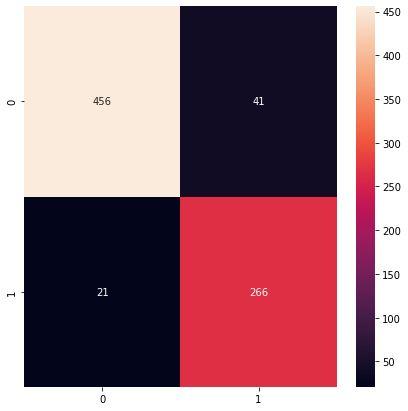

In [46]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True,fmt='d')
plt.show()

In [47]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       497
           1       0.87      0.93      0.90       287

   micro avg       0.92      0.92      0.92       784
   macro avg       0.91      0.92      0.92       784
weighted avg       0.92      0.92      0.92       784



/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [48]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [49]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.2,random_state=42)
X_test, X_val = train_test_split(X_val, test_size=0.5,random_state=42)

In [50]:
X_train.shape,X_test.shape, X_val.shape

((1098, 4), (137, 4), (138, 4))

In [51]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [52]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [53]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [54]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [55]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [56]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
"""@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}"""

In [57]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import tversky_loss, tversky

In [58]:
def focal_tversky(y_true,y_pred):
    ## IMPORTANT NOTE:
    ## It seems that the type of y_true and y_pred are not the same. One is of type
    ## float32 and other int64. They need to be cast as the same type for the training
    ## to actually work.
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #print(type(y_pred))
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [59]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=25
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/workingResUNet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [60]:
history = model_seg.fit(training_generator, epochs = 1000, validation_data = validation_generator,
                        callbacks = [checkpointer, earlystopping,reduce_lr])

Epoch 1/1000
68/68 [==============================] - 18s 200ms/step - loss: 0.8726 - tversky: 0.1652 - val_loss: 0.8606 - val_tversky: 0.1813

Epoch 00001: val_loss improved from inf to 0.86056, saving model to /kaggle/workingResUNet-weights.hdf5
Epoch 2/1000
68/68 [==============================] - 13s 186ms/step - loss: 0.5502 - tversky: 0.5438 - val_loss: 0.5798 - val_tversky: 0.5141

Epoch 00002: val_loss improved from 0.86056 to 0.57976, saving model to /kaggle/workingResUNet-weights.hdf5
Epoch 3/1000
68/68 [==============================] - 13s 187ms/step - loss: 0.4049 - tversky: 0.6980 - val_loss: 0.3927 - val_tversky: 0.7096

Epoch 00003: val_loss improved from 0.57976 to 0.39268, saving model to /kaggle/workingResUNet-weights.hdf5
Epoch 4/1000
68/68 [==============================] - 13s 190ms/step - loss: 0.3452 - tversky: 0.7562 - val_loss: 0.4339 - val_tversky: 0.6698

Epoch 00004: val_loss did not improve from 0.39268
Epoch 5/1000
68/68 [==============================] -

In [61]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("/kaggle/working/ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

In [62]:
from utilities import focal_tversky, tversky_loss, tversky

with open('/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [63]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [64]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred.head()

image_path  \
0  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...   
1  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...   
3  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...   
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...   

                                      predicted_mask  has_mask  
0  [[[[5.843522e-07], [2.0867994e-06], [4.203415e...         1  
1                                            No mask         0  
2                                            No mask         0  
3                                            No mask         0  
4                                            No mask         0

In [65]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...   
1  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...   
3  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...   
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...   

                                           mask_path mask  \
0  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...    1   
1  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...    0   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...    0   
3  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...    0   
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...    0   

                                      predicted_mask  has_mask  
0  [[[[5.843522e-07], [2.0867994e-06], [4.203415e...         1  
1                                            No mask         0  
2                                            No mask         0  
3                                            No mask         0  
4                                            No mask         0

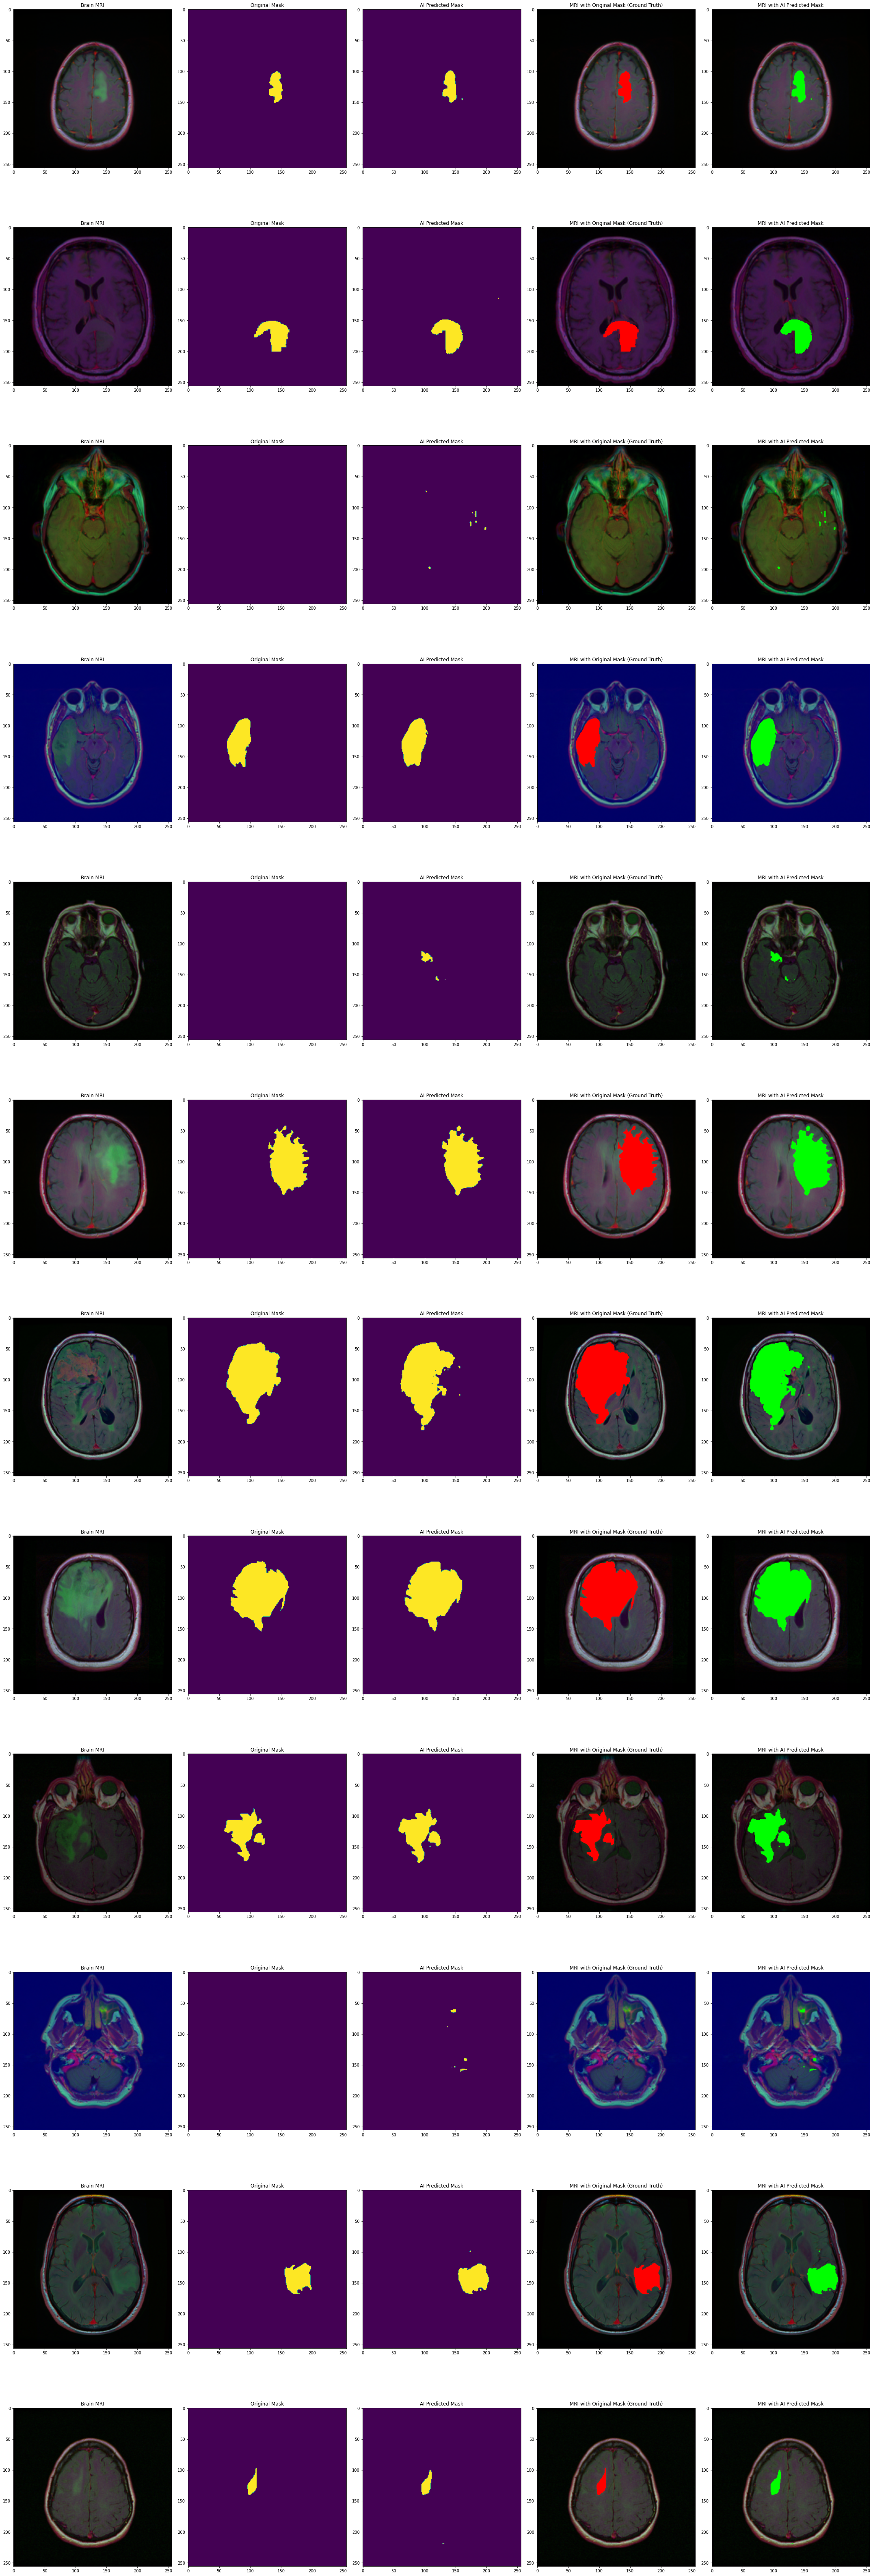

In [66]:
count = 0 
fig, axs = plt.subplots(12, 5, figsize=(30,90))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 12:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()